# Stock Predictor

In [2]:
!pip install yfinance xgboost

  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached xgboost-3.0.5-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached multitasking-0.0.12-py3-none-any.whl
  Using cached frozendict-2.4.6-py312-none-any.whl.metadata (23 kB)
  Using cached peewee-3.18.2-cp312-cp312-linux_x86_64.whl
  Using cached curl_cffi-0.13.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached websockets-15.0.1-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
Using cached yfinance-0.2.66-py2.py3-none-any.whl (123 kB)
Using cached xgboost-3.0.5-py3-none-manylinux_2_28_x86_64.whl (94.9 MB)
Using cached curl_cffi-0.13.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
Using cached frozendict-2.4.6-py312-none-any.whl (16 kB)
Using cached websockets-15.0.1-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def load_stock_data(ticker: str, start: str = "2025-01-01", end: str = None):
    """
    Loads daily OHLCV data for a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): Stock ticker symbol (e.g., 'AAPL')
        start (str): Start date for data (default: '2015-01-01')
        end (str): End date for data (default: today)

    Returns:
        pd.DataFrame: DataFrame containing stock data
    """
    print(f"Fetching data for {ticker}...")
    data = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
    data = data.rename(columns=str.lower)
    return data

In [4]:
def create_features(data: pd.DataFrame, lag: int = 30):
    """
    Converts OHLCV data into supervised learning features for next-day prediction.

    Args:
        data (pd.DataFrame): Daily stock data with columns ['open','high','low','close','volume']
        lookback (int): Number of past days used as features

    Returns:
        X (pd.DataFrame): Feature matrix
        y (pd.Series): Target values (next-day close)
    """
    df = data.copy()

    # compute daily returns
    #df["return"] = df["close"].pct_change()

    df = df.dropna()

    features = []
    targets = []
    target_dates = []
    feature_dates = []

    for i in range(lag, len(df)):
        window = df.iloc[i - lag:i]
        next_close = df.iloc[i]["close"]
        next_date = df.index[i]
        window_dates = df.index[i - lag:i]

        # flatten window data (close & volume)
        feat = np.concatenate([
            window["close"].values.flatten(),
            window["volume"].values.flatten()
        ])
        features.append(feat)
        targets.append(next_close)
        target_dates.append(next_date)
        feature_dates.append(window_dates)

    X = np.array(features)
    y = np.array(targets).flatten()
    target_dates = np.array(target_dates)
    return X, y, target_dates, feature_dates



In [5]:
def walk_forward_sliding_window(X, y, target_dates, train_window=200, step=1, params=None):
    """
    Walk-forward validation with a sliding training window for next-day stock prediction.

    Args:
        X (np.ndarray): Feature matrix
        y (np.ndarray): Target vector
        target_dates (np.ndarray): Corresponding dates
        train_window (int): Number of past samples used for training at each step
        step (int): How many steps to move the window forward each iteration
        params (dict): Hyperparameters for XGBRegressor

    Returns:
        results (pd.DataFrame): DataFrame with date, actual, predicted
        metrics (dict): Overall MAE and RMSE
    """
    if params is None:
        params = {
            "n_estimators": 600,
            "learning_rate": 0.03,
            "max_depth": 5,
            "min_child_weight": 5,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "gamma": 0.2,
            "reg_lambda": 2.0,
            "reg_alpha": 0.5,
            "objective": "reg:squarederror",
            "eval_metric": "mae",
            "random_state": 42,
        }

    n_samples = len(X)
    predictions = []
    actuals = []
    dates = []

    start_idx = train_window
    for i in range(start_idx, n_samples, step):
        train_idx = slice(i - train_window, i)
        test_idx = i

        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx:test_idx+1], y[test_idx:test_idx+1]

        model = XGBRegressor(**params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        predictions.append(y_pred[0])
        actuals.append(y_test[0])
        dates.append(target_dates[test_idx])

    results = pd.DataFrame({
        "date": dates,
        "actual": actuals,
        "predicted": predictions
    }).set_index("date")

    mae = mean_absolute_error(results["actual"], results["predicted"])
    rmse = np.sqrt(mean_squared_error(results["actual"], results["predicted"]))
    mape = np.mean(np.abs((results["actual"] - results["predicted"]) / results["actual"])) * 100

    # Directional Accuracy (DA)
    actual_change = np.sign(results["actual"].diff())
    predicted_change = np.sign(results["predicted"].diff())
    da = np.mean(actual_change[1:] == predicted_change[1:]) * 100

    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "Directional_Accuracy": da
    }

    print(f"\nWalk-forward (sliding window) metrics:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"DA:   {da:.2f}%")

    return results, metrics

In [6]:
def optimize_window_sizes(data, lag_values, train_window_values, ticker="MSFT"):
    """
    Simple grid search over lag and train_window sizes using walk-forward validation.

    Args:
        data (pd.DataFrame): Stock data (OHLCV)
        lag_values (list): Candidate lag values (e.g. [5, 10, 20, 30])
        train_window_values (list): Candidate train_window sizes (e.g. [50, 100, 200])
        ticker (str): Ticker symbol for reporting

    Returns:
        pd.DataFrame: Results sorted by MAE
    """
    results_summary = []

    for lag in lag_values:
        X, y, target_dates, _ = create_features(data, lag)
        for tw in train_window_values:
            if tw >= len(X) // 2:
                continue
            print(f"\nTesting lag={lag}, train_window={tw}...")
            try:
                _, metrics = walk_forward_sliding_window(X, y, target_dates, train_window=tw)
                results_summary.append({
                    "lag": lag,
                    "train_window": tw,
                    **metrics
                })
            except Exception as e:
                print(f"  ❌ Failed for lag={lag}, train_window={tw}: {e}")

    df_results = pd.DataFrame(results_summary)
    df_results = df_results.sort_values("MAE")
    print("\n=== Optimization Results (sorted by MAE) ===")
    print(df_results.head(10))
    return df_results

In [7]:
def plot_walk_forward_results(results: pd.DataFrame, ticker: str = "MSFT"):
    """
    Plots walk-forward prediction results:
    - Actual vs predicted prices
    - Prediction error over time

    Args:
        results (pd.DataFrame): DataFrame with 'actual' and 'predicted' columns indexed by date
        ticker (str): Stock ticker for title
    """
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
                           gridspec_kw={'height_ratios': [3, 1]})

    ax[0].plot(results.index, results["actual"], label="Actual", color="black")
    ax[0].plot(results.index, results["predicted"], label="Predicted", color="red", alpha=0.7)
    ax[0].set_ylabel("Close Price")
    ax[0].set_title(f"{ticker} — Next-Day Close Prediction (Walk-Forward, Sliding Window)")
    ax[0].legend(loc="upper left")
    ax[0].grid(True, linestyle="--", alpha=0.4)

    errors = results["predicted"] - results["actual"]
    ax[1].plot(results.index, errors, color="blue", alpha=0.6)
    ax[1].axhline(0, color="black", linewidth=1)
    ax[1].set_ylabel("Prediction Error")
    ax[1].set_xlabel("Date")
    ax[1].grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()



In [8]:
def plot_sample(X: np.ndarray, y: np.ndarray, target_dates: np.ndarray, feature_dates: list, 
                sample_idx: int = 0, lag: int = 30, ticker: str = "MSFT"):
    """
    Plots the feature vector (closing prices and volumes) for a given sample,
    and shows the next-day target price.

    Args:
        X (np.ndarray): Feature matrix (n_samples, lookback*2)
        y (np.ndarray): Target array (n_samples,)
        sample_idx (int): Index of the sample to visualize
        lookback (int): Number of past days used in features
        ticker (str): Stock ticker for title
    """
    first_features = X[sample_idx]
    first_target = y[sample_idx]
    target_date = target_dates[sample_idx]
    window_dates = feature_dates[sample_idx]

    closes = first_features[:lag]
    volumes = first_features[lag:]

    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color=color)
    ax1.plot(window_dates, closes, marker='o', color=color, label='Past closes')
    ax1.scatter(target_date, first_target, color='red', label='Next day target')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Volume', color=color)
    ax2.bar(window_dates, volumes, alpha=0.3, color=color, label='Past volumes')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(f'{ticker} - Sample {sample_idx} features (closes + volumes) vs. next-day target')
    plt.show()

    

In [9]:
ticker = "MSFT"
data = load_stock_data(ticker, start="2023-01-01")

lag_values = [3, 5, 7, 10, 12, 15, 17, 20, 30]
train_window_values = [50, 75, 100, 125, 150, 200]

results_df = optimize_window_sizes(data, lag_values, train_window_values, ticker)

best = results_df.iloc[0]
print(f"\nBest configuration: lag={best.lag}, train_window={best.train_window}")

Fetching data for MSFT...

Testing lag=3, train_window=50...

Walk-forward (sliding window) metrics:
MAE:  5.9051
RMSE: 7.7960
MAPE: 1.50%
DA:   49.38%

Testing lag=3, train_window=75...

Walk-forward (sliding window) metrics:
MAE:  5.7059
RMSE: 7.3794
MAPE: 1.44%
DA:   50.57%

Testing lag=3, train_window=100...

Walk-forward (sliding window) metrics:
MAE:  5.5222
RMSE: 7.2779
MAPE: 1.36%
DA:   50.00%

Testing lag=3, train_window=125...

Walk-forward (sliding window) metrics:
MAE:  5.4170
RMSE: 7.1392
MAPE: 1.33%
DA:   50.26%

Testing lag=3, train_window=150...

Walk-forward (sliding window) metrics:
MAE:  5.4271
RMSE: 7.1423
MAPE: 1.31%
DA:   49.26%

Testing lag=3, train_window=200...

Walk-forward (sliding window) metrics:
MAE:  5.6373
RMSE: 7.3554
MAPE: 1.34%
DA:   48.79%

Testing lag=5, train_window=50...

Walk-forward (sliding window) metrics:
MAE:  5.8186
RMSE: 7.7067
MAPE: 1.48%
DA:   47.66%

Testing lag=5, train_window=75...

Walk-forward (sliding window) metrics:
MAE:  5.5848



Walk-forward (sliding window) metrics:
MAE:  5.5396
RMSE: 7.2355
MAPE: 1.36%
DA:   48.82%


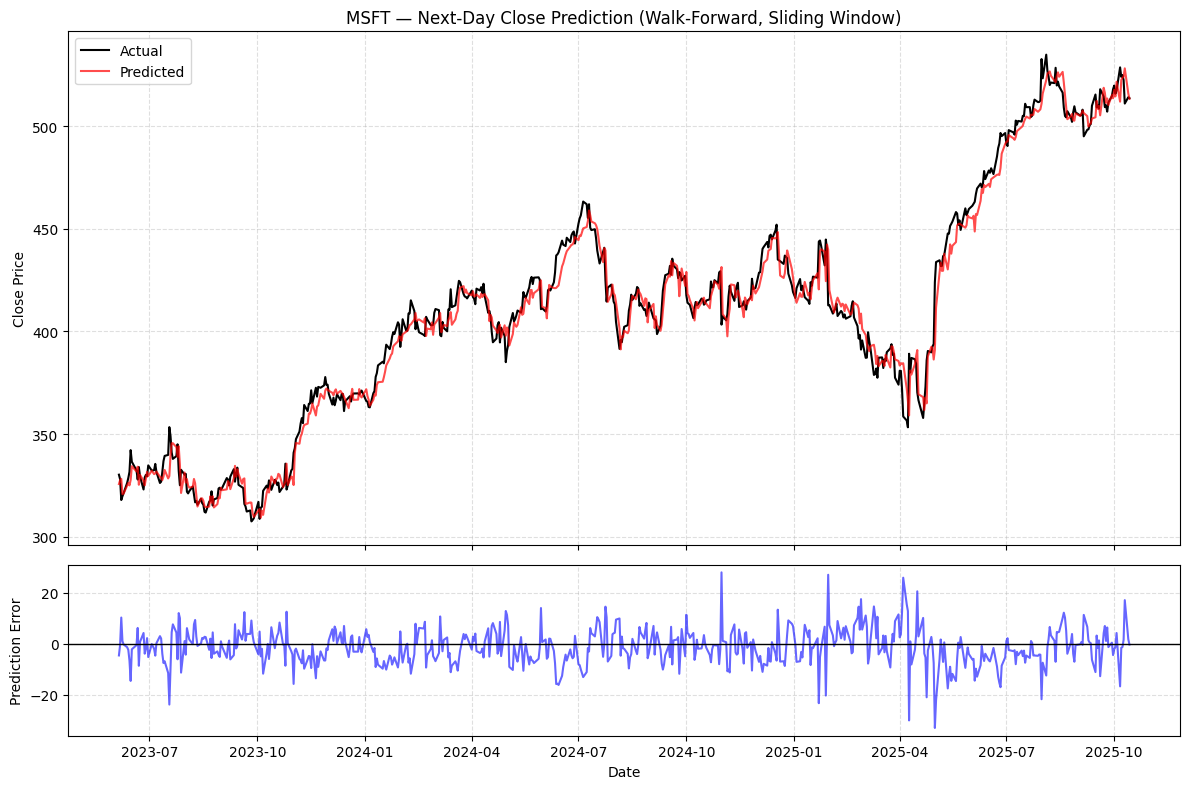

In [10]:
lag = 5
X, y, target_dates, feature_dates = create_features(data, lag)

results, metrics = walk_forward_sliding_window(
    X, y, target_dates,
    train_window=100,
    step=1 # predict daily
)
plot_walk_forward_results(results, ticker)


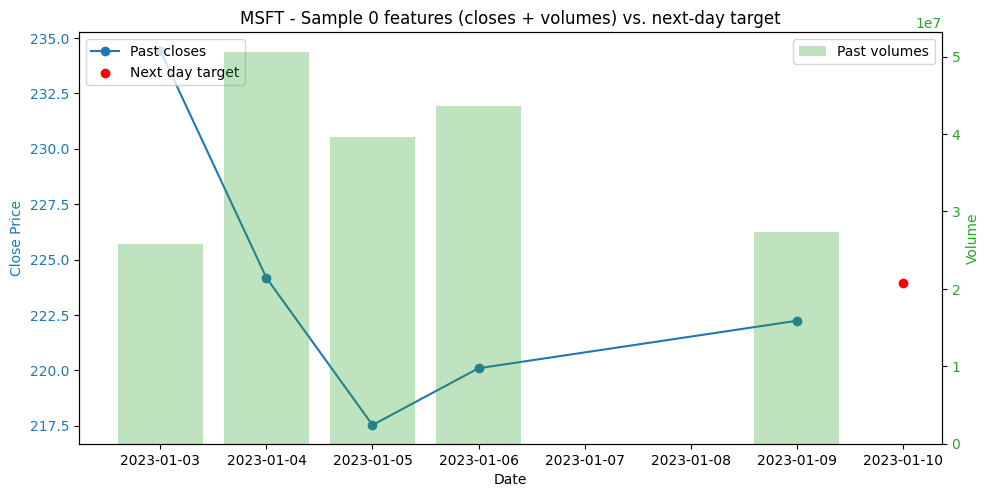

In [11]:
plot_sample(X, y, target_dates, feature_dates, sample_idx=0, lag=lag, ticker=ticker)